In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

from torchinfluence.methods.TracIn import GradientSimilarity

This notebook exemplifies the usage of the `GradientSimilarity` class in `torchinfluence.methods.TracIn` on the MNIST dataset using a simple neural network.

It takes in a model, loss function as well as train and test datasets and produces a scoring table in the form of a `numpy.ndarray`. The scores express similarity between gradients for a train and test point. The similarity is either simply expressed the dot product between two gradient vectors or as the cosine similarity if `normalize=True` in the `score`-method.

We can think of the gradient similarity as done in TracIn [2] (which is closely related to [1]) which interprets the gradient similarity score as an importance or influence score, i.e. how important was training point x for test point z.



[1] Pruthi et al.: https://proceedings.neurips.cc/paper_files/paper/2019/file/c61f571dbd2fb949d3fe5ae1608dd48b-Paper.pdf <br>
[2] Charpiat et al.: https://proceedings.neurips.cc/paper_files/paper/2020/file/e6385d39ec9394f2f3a354d9d2b88eec-Paper.pdf

In [2]:
mnist = load_dataset("mnist")


class MNISTDataset(Dataset):
    def __init__(self, dataset, split="train", device="cpu"):
        self.dataset = dataset
        self.split = split
        self.device = device

    def __getitem__(self, idx):
        item = self.dataset[self.split][idx]
        x = torch.tensor((np.asarray(item["image"]) / 255).reshape(-1, 28 * 28)).float()
        y = torch.tensor(item["label"]).long()

        x = x.to(device=self.device)
        y = y.to(device=self.device)

        return x, y

    def __len__(self):
        return len(self.dataset[self.split])


device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = MNISTDataset(mnist, split="train", device=device)
test_dataset = MNISTDataset(mnist, split="test", device=device)

In [3]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size))

    def forward(self, x):
        return self.model(x)


model = FeedForward(28 * 28, 128, 10).to(device=device)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=32)

epochs = 5
checkpoints = {f"cp-{i}": None for i in range(epochs)}
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

for epoch in range(epochs):
    for x, y in train_dataloader:
        optimizer.zero_grad()
        loss = F.cross_entropy(model(x).squeeze(1), y)
        loss.backward()
        optimizer.step()
    checkpoints[f"cp-{epoch}"] = model.state_dict()
    print(f"Epoch {epoch+1}/{epochs} loss: {loss.item()}")

Epoch 1/5 loss: 0.19419021904468536
Epoch 2/5 loss: 0.12879829108715057
Epoch 3/5 loss: 0.10333287715911865
Epoch 4/5 loss: 0.08390262722969055
Epoch 5/5 loss: 0.0708363801240921


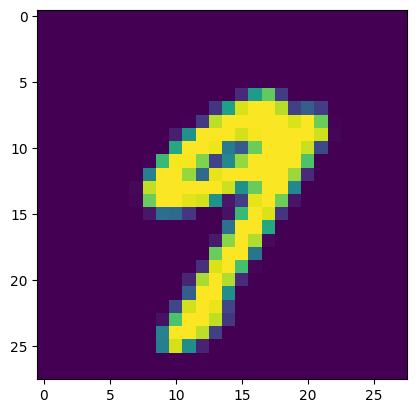

In [5]:
test_idx = 20
plt.imshow(test_dataset[test_idx][0].reshape(28, 28))
plt.show()

In [6]:
gradsim = GradientSimilarity(model, F.cross_entropy, device="cpu")
scores = gradsim.score(train_dataset, test_dataset, subset_ids={"test": [test_idx]}, normalize=True, chunk_size=1000)

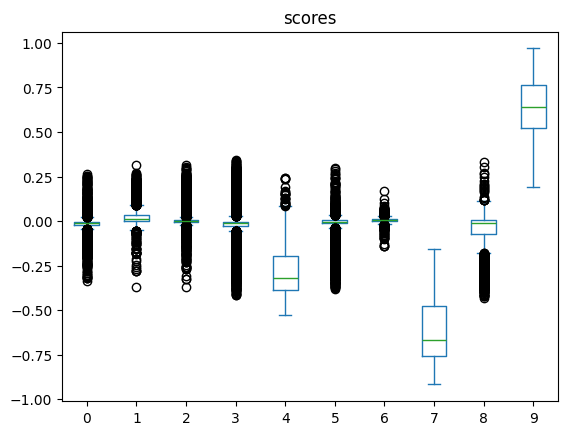

In [7]:
train_labels = train_dataset.dataset["train"]["label"]
pd.DataFrame({"scores": scores[0], "labels": train_labels}).plot.box(by="labels")
plt.show()

# Interpretation of plot

Seeing the grouped boxplots we clearly see that the 9's in the training data is consistently attributed a higher score than the rest of the classes. Meanwhile, we see that the 7's actually have a consistently low score. This can be interpreted as the 7's being *opponents* of the test point in question being classified as a 9, which intuitively makes sense given that the test image has lots of the same characteristics as a 7.